In [62]:
import keras
import tensorflow as tf

from IPython.display import display
import PIL 

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3546928259394249379
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6614766059
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11738451063608630592
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
print(tf.__version__)

2.0.0


In [6]:
df = pd.read_csv('original_full_data.csv', index_col = 0)

In [7]:
mmdf = pd.read_csv('bloomberg_map_index_20200130.csv', index_col = 0)

In [8]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df = df.loc[9132 :, :]

In [10]:
len(df)

5051

In [11]:
df.reset_index(inplace = True, drop = True)

In [12]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = self.df[target_column].shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0)

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [56]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [13]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [14]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [15]:
df.isna().sum().sum()

0

In [16]:
cla = Builder(df, mmdf, 1)

In [17]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [18]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [19]:
df.reset_index(inplace = True)

In [20]:
TRAIN_SPLIT = 4000 # 3000부터 대강 쪼개면 될듯

In [21]:
tf.random.set_seed(13)

In [22]:
def create_time_steps(length): # 이전 len 5 4 3 2 1 이렇게 스텝 생성하는 function
    return list(range(-length, 0))

In [23]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']

    time_steps = create_time_steps(plot_data[0].shape[0]) # 들어가는 plot_data 는 x_train_uni , 20개 하고 label y_train_uni 하나니까 그래프가 저렇게 

    if delta: # delta는 y_train 
        future = delta # 확인 결과 True난 1이거나 값이 있으면 실행 False, 0 , None인 경우 미 실행 delta가 값이 있으면 그걸로 받는것이다 (1이상))
    else :
        future = 0



    plt.title(title) # 이건 걍 title
    for i, x in enumerate(plot_data): # plot data 순회 -> 마지막 깨달음 아 시박 x y가 둘 다 들어갔으니 당연히 0, 1이지 시발

        if i: # 0이면 ? plot_data [0] 에 대해서만 이 그림을 그리고 처음에 밑그림을 그릴 필요가 있어서 이렇게 짠거인듯. 0 False None 빼고 다 출력
                        
            plt.plot(future, plot_data[i], marker[i], markersize = 5, # else를 보고 이걸 보면.. 처음에 전체 데이터를 가지고 그림을 그린 다음 그냥 마지막 것만 실행하며 덧씌우고
                     # future를 가지고 True Future 점을 하나 찍는 형태가 된거임. 
                     label = labels[i]) # label 의 1이 적용이 된건데? marker의 1이 적용이 되고, plot
            
        else: # 0 False None 인경우 인듯. 0인 경우 그림을 그림 time_steps plot_data[i] (x_train_uni0길이만큼 정수 : 0 ~ 20) flatten을 하는 이유는 그냥 한줄로 넣으려고. np는그게도나봄. 
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i]) # label도 label의 0~ 20번째 근데 라벨값은 하나아냐?  아 0이니까. 
    # 점을 찍었다면 x축은 어디가 되는건가? 아 알겠군 -> time step이 필요했던건 real값과 prediction값을 다른 선상에 두기 위해서였다. 
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')

    return plt

In [24]:
features_considered = ['SKhynix_change', 'Philadelphia_change', 'Micron_change', 'MediaTek_change', 'USDollarIndex_close', 'FRNTTNETIndex', 'Intel_product', 'USD_KRW_change', 'CPUPXCHGIndex', 'KOBONTLIndex', 'RSTAMOMIndex', 'KOEXPTIYIndex', 'KOCPIMOMIndex', 'Dell_close', 'Dell_volume', 'GPGSTOC%Index', 'SKLIOTARIndex', 'Nvidia_volume', 'SKCIMOMIndex', 'KOCGCGYIndex', 'KOECPRCYIndex', 'LEIBPIndex', 'AMD_change', 'JOLTSEPSIndex', 'HPE_close', 'Sumco_change', 'KOGFBALIndex', 'CNFREXPYIndex', 'TokyoElectron_close', 'EUR_KRW_close', 'KOBPFINIndex', 'Amazon_change', 'UMC_product', 'KOECGVTYIndex', 'KOBPCAIndex', 'KOECIMPYIndex', 'NAPMNMIIndex', 'USWHTOTIndex', 'Amazon_volume', 'KOECFCSYIndex', 'Google_product', 'KOFDITYIndex', 'KOQEEYOYIndex', 'TokyoElectron_volume', 'CNGDPYOYIndex', 'MBRXYOYWIndex', 'ShinEtsuChemical_volume', 'USTBEXPYIndex', 'AppliedMaterials_product', 'QCOM_product', 'SKhynix_product', 'UMC_volume', 'APPLE_product', 'KOECSIMQIndex', 'SKLICPYIndex', 'SKLICONEIndex', 'LEIMNOIndex', 'SAARDTOTIndex', 'KOBPCBIndex', 'USHEYOYIndex', 'USEMNCHGIndex', 'MGT2MAIndex', 'KOPPIMOMIndex', 'KOIVCONYIndex', 'Intel_volume', 'g16', 'AMD_product', 'KOEXTOTIndex', 'KOFETOTIndex', 'SKLINBARIndex', 'ssd_price', 'SKLILAPIndex', 'KOCPIIndex', 'TSMC_product', 'KOPPIYOYIndex', 'Philadelphia_volume', 'APPLE_volume', 'RSTAYOYIndex', 'Micron_product', 'Micron_volume', 'PITLCHNGIndex', 'SAARTOTLIndex', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'TokyoElectron_change', 'Intel_change', 'KOWDRIndex', 'Nvidia_product', 'ShinEtsuChemical_close', 'memory_price', 'NFPTCHIndex', 'NFPPCHIndex', 'KOGDPYOYIndex', 'KOEAEPRIndex', 'USGG3MIndex', 'SKLILAIIndex']

In [25]:
target_considered = ['KRXsemiconductor_change']

In [26]:
targets = df[target_considered]
features = df[features_considered]

In [27]:
features.index = df['date']
targets.index = df['date']

In [28]:
col_name = features.columns
dataset = MinMaxScaler().fit_transform(features)# Standard
dataset = pd.DataFrame(dataset, columns = col_name)

In [29]:
X_data = dataset

In [30]:
y_target = targets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [32]:
X_train = X_train.values

In [33]:
y_train = y_train.values

In [34]:
X_test = X_test.values

In [35]:
y_test = y_test.values

In [36]:
type(X_train)

numpy.ndarray

In [37]:
dataset.shape

(5051, 98)

In [38]:
X_train.shape

(4040, 98)

In [39]:
X_train_t = X_train.reshape(X_train.shape[0], 98, 1)

In [40]:
X_train_t.shape

(4040, 98, 1)

In [41]:
X_test_t = X_test.reshape(X_test.shape[0], 98, 1)

In [42]:
X_train_t.shape, X_test_t.shape

((4040, 98, 1), (1011, 98, 1))

In [43]:
# rmse custorm metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [44]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(LSTM(20, input_dim=(98, 1), activation='relu'))
    model.add(Dense(1), activation = 'relu')
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='rmsprop', metrics = [root_mean_squared_error])
    return model

In [45]:
K.clear_session()

# define  model
def deep_lstm():
    # create sequntial model
    model = Sequential()
    model.add(LSTM(128, input_shape = (98, 1 ), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(16, return_sequences = False))
    model.add(Dense(1, activation = 'relu'))    
    adam = optimizers.Adam(lr = 0.01)
    # compile model
    model.compile(loss = root_mean_squared_error, optimizer = 'adam', metrics = ['accuracy', root_mean_squared_error]) #or adam, loss = 'mean_squared_error'
    
    return model

In [46]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [47]:
import keras.backend.tensorflow_backend as K

In [50]:

K.clear_session()

with tf.device('/gpu:0'):
    model = Sequential()
    model.add(LSTM(64, input_shape = (98, 1), return_sequences = True))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences = True))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences = True))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())

    model.add(LSTM(64, return_sequences = False))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())

    model.add(Dense(1, activation = 'tanh')) 

    rmsprop = optimizers.rmsprop(lr = 0.01)
    
    # compile model

    model.compile(loss='mse',
                  optimizer=rmsprop,
                  metrics=[root_mean_squared_error])
    h = model.fit(X_train_t, y_train, epochs=30,
          batch_size=100, verbose=1, callbacks=[early_stop])

Epoch 1/30
4040/4040 [==============================] - 12s 3ms/step - loss: 5.0908 - root_mean_squared_error: 1.6147
Epoch 2/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.7640 - root_mean_squared_error: 1.5305
Epoch 3/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.6362 - root_mean_squared_error: 1.5064
Epoch 4/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.6309 - root_mean_squared_error: 1.5004
Epoch 5/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.6172 - root_mean_squared_error: 1.4962
Epoch 6/30
4040/4040 [==============================] - 10s 3ms/step - loss: 4.5935 - root_mean_squared_error: 1.4956
Epoch 7/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.6284 - root_mean_squared_error: 1.4967
Epoch 8/30
4040/4040 [==============================] - 11s 3ms/step - loss: 4.5938 - root_mean_squared_error: 1.4915
Epoch 9/30
4040/4040 [==============================] - 

In [51]:
y_pred = model.predict(X_test_t)

In [52]:
y_pred.shape

(1011, 1)

In [53]:
y_test.shape

(1011, 1)

In [54]:
y_pred = np.reshape(y_pred, (1011))
y_test = np.reshape(y_test, (1011))

In [57]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.045415,0.0012,1.4592,1.9709,0.533136,0.52071


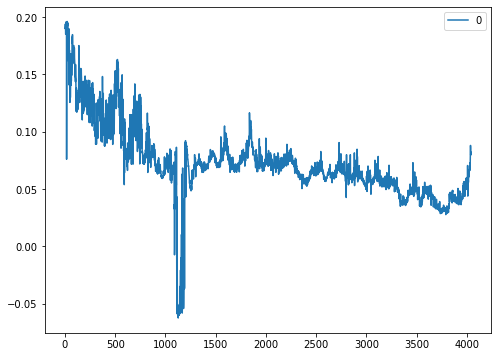

In [61]:
pd.DataFrame(model.predict(X_train_t)).plot()

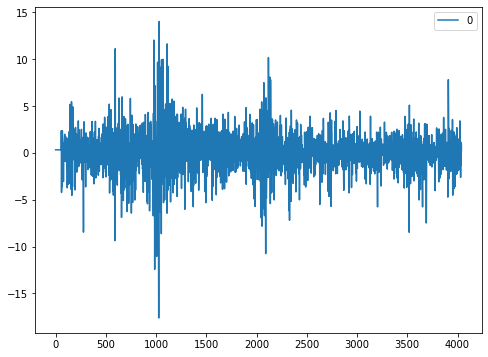

In [60]:
pd.DataFrame(y_train).plot()

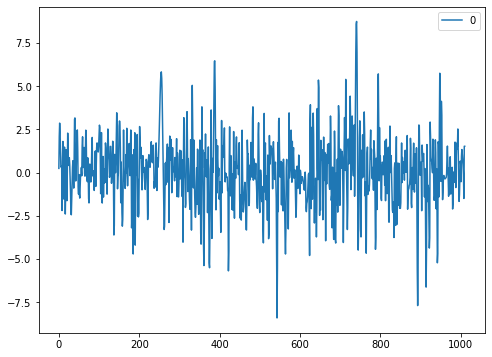

In [58]:
pd.DataFrame(y_test).plot()

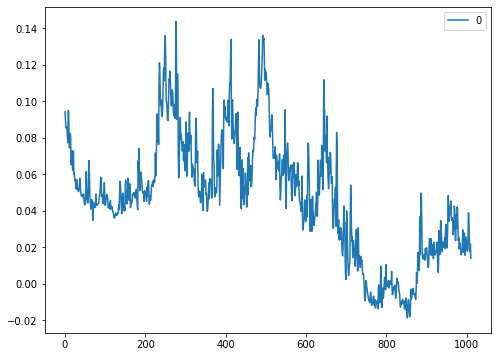

In [59]:
pd.DataFrame(y_pred).plot()

In [46]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [47]:
base_model = KerasRegressor(build_fn = baseline_model)
lstm_model = KerasRegressor(build_fn = deep_lstm)

In [48]:
lstm_model.fit(X_train_t, y_train, epochs=30,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/30
4040/4040 [==============================] - 39s 10ms/step - loss: 1.4852 - accuracy: 0.0015 - root_mean_squared_error: 1.4852
Epoch 2/30
4040/4040 [==============================] - 37s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 3/30
4040/4040 [==============================] - 37s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 4/30
4040/4040 [==============================] - 37s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 5/30
4040/4040 [==============================] - 36s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 6/30
4040/4040 [==============================] - 36s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 7/30
4040/4040 [==============================] - 36s 9ms/step - loss: 1.4850 - accuracy: 0.0015 - root_mean_squared_error: 1.4850
Epoch 00007: early stopping


In [171]:
# evaluate는 keras regressor 에서 돌아가지 않으므로 폐기
#score = lstm_model.evaluate(X_test_t, y_test, batch_size = 30)
#print(score)

In [102]:
y_pred = model.predict(X_test_t)

In [110]:
y_test.shape

(1011, 1)

In [112]:
y_test = np.reshape(y_test, (1011))

In [116]:
y_test

array([ 0.24      ,  2.08      ,  2.85915286, ..., -1.5       ,
        1.52      ,  1.52      ])

In [122]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [59]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.180667,0.0300,1.4500,1.9423,0.548961,0.558185


In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(X, y)
prediction = estimator.predict(X_test)
accuracy_score(Y_test, prediction)

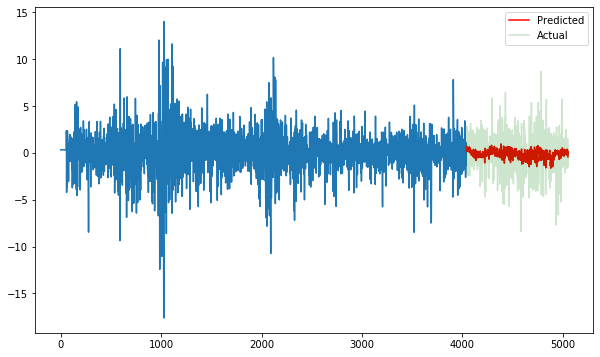

In [306]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(4040,), '-')
plt.plot(b_axis, y_pred.reshape(1011,), '-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1011,), '-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

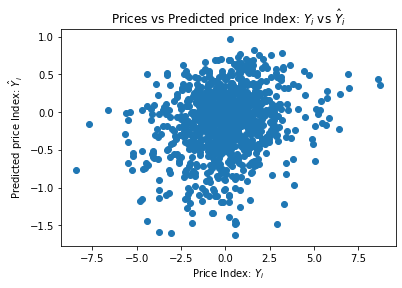

In [279]:



y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")

In [58]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [288]:
X_test_t.shape

(1011, 98, 1)

In [291]:
y_test.shape

(1011, 1)

In [289]:
y_pred.shape

(1011, 1)

In [297]:
mt_yt = np.reshape(y_test, (1011))

In [298]:
mt_yp = np.reshape(y_pred, (1011))

In [299]:
mt_yt.shape

(1011,)

In [296]:
type(y_test)

numpy.ndarray

In [295]:
type(y_pred)

numpy.ndarray

In [300]:
metr = CustomMetric(mt_yp, mt_yt)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.210784,0.0375,1.4462,1.9348,0.542038,0.571992


In [171]:
def multi_data(dataset, target, start_index, end_index):
    
    data = []
    labels = []        
    
    for i in range(start_index, end_index):
        data.append(dataset[i]) # 한 줄씩 라벨을 만나야함
        labels.append(target[i])
        # 값이 그냥 하나씩만 들어가게 
        
    return np.array(data), np.array(labels)

In [172]:
len(dataset)

5051

In [173]:
x_train_single, y_train_single = multi_data(dataset, targets, 0, 
                                                   TRAIN_SPLIT)

x_val_single, y_val_single = multi_data(dataset, targets,
                                               TRAIN_SPLIT, 5051)

In [214]:
x_train_single.shape, y_train_single.shape

((1, 4000, 98), (1, 4000, 1))

In [215]:
x_val_single.shape, y_val_single.shape

((1, 1051, 98), (1, 1051, 1))

In [221]:
x_train_single[0][0].shape

(98,)

In [183]:
x_train_single = np.reshape(x_train_single, (1, 4000, -1))
y_train_single = np.reshape(y_train_single, (1, 4000, -1))

In [192]:
x_val_single = np.reshape(x_val_single, (1, 1051, -1))
y_val_single = np.reshape(y_val_single, (1, 1051, -1))

In [151]:
'''
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, single_step = False):
    
    data = []
    labels = []

    start_index = start_index + history_size # dataset : dataset.values(numpy)- feature 전체 데이터 target : target, target 한 줄, 
    # start_index : 0 , end_index : TRAIN_SPLIT ( 30000) , history_size : past_history ( 몇 개를 예측) , target_size : future_target(72개를 예측)
    # strp : 6 ? 6개씩만 뽑는건가?

    if end_index is None:
        end_index = len(dataset) - target_size # validation에서는 end index를 갖지 않고 한다. end_index = dataset길이에서 target size를 뺀 것. 72를 뺀것.  4979.

    
    for i in range(start_index, end_index): # start_index ? TRAIN은 0 부터 TRAIN_SPLIT까지 validation의 경우는 TRAIN_SPLIT부터 시작해서 4979까지 
        # 아 이건 다 해서 마지막 target만 예측하는거구나. 다 하고나서 72개만. 이런식이면 풀 prediction은 안되겠는데. trainsplit한 뒷부분 전체가 되야 하는거 아닌가?
        indices = range(i-history_size, i, step) # train의 경우 0부터 시작. 0- history_size 720? 근데이미  start_index에 720을 더해놨으ㅡㅁ로 
        data.append(dataset[indices]) # step이 6이면 0, 6, 12, 18, 24..번째 데이터가 쭉 들어가서 총 120개가 들어갔겟지. 

        if single_step:
            labels.append(target[i + target_size])
        
        else:
            labels.append(target[i: i + target_size]) # target에서 720 : 720 + target size 72개 까지 들어감. 

        return np.array(data), np.array(labels)
'''

In [86]:
# 아마 데이터셋도 72개의 세트겠지. 이제 알겠네. target은 72개고 그전에 

In [36]:
past_history = 720
future_target = 72
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEP = 6

In [152]:
'''
x_train_single, y_train_single = multivariate_data(dataset, targets, 0, 
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step = True)

x_val_single, y_val_single = multivariate_data(dataset, targets,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step = True)
                                               
'''

In [159]:
x_train_single

[array([[ 1.87260529,  1.35206379,  0.39399339, ..., -1.31760748,
          1.79390704, -1.48124364],
        [ 1.18298121,  0.68233835,  0.9349131 , ..., -1.31760748,
          1.85903734, -1.48124364],
        [ 0.06125268,  0.09744527, -0.23043871, ..., -1.31760748,
          1.9525778 , -1.48124364],
        ...,
        [ 0.20343158,  1.16406296,  1.03861213, ...,  0.47554191,
          1.1642336 , -0.94054021],
        [-0.56561181, -0.98512831, -1.04323048, ...,  0.27097884,
          1.068879  , -0.9361963 ],
        [-0.36752487, -0.74727878, -1.4194671 , ...,  0.03040382,
          1.11890008, -0.93366509]])]

In [197]:
print('Single window of past history : {}'.format(x_train_single[0].shape))
print('Single window of past history : {}'.format(y_train_single[0].shape))

Single window of past history : (4000, 98)
Single window of past history : (4000, 1)


In [201]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # shuffle option은 들어가는 게 맞나? batch는 256개 씩

In [202]:
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [204]:
# early stopping을 넣어보자
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5)

In [205]:
y_train_single.shape

(1, 4000, 1)

In [206]:
np.array([x_train_single]).shape

(1, 1, 4000, 98)

In [207]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape = x_train_single.shape[-2:], return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(16, activation = 'sigmoid'))
single_step_model.add(tf.keras.layers.Dense(1))

In [208]:
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(),
                          loss = 'mse')

In [209]:
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4000, 32)          16768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4000, 32)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4000, 32)          8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 4000, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
__________________________________________________

In [231]:
for i, j in train_data_single.take(3):
    print(j)

tf.Tensor(
[[[0.33]
  [0.33]
  [0.33]
  ...
  [2.39]
  [1.21]
  [1.46]]], shape=(1, 4000, 1), dtype=float64)
tf.Tensor(
[[[0.33]
  [0.33]
  [0.33]
  ...
  [2.39]
  [1.21]
  [1.46]]], shape=(1, 4000, 1), dtype=float64)
tf.Tensor(
[[[0.33]
  [0.33]
  [0.33]
  ...
  [2.39]
  [1.21]
  [1.46]]], shape=(1, 4000, 1), dtype=float64)


In [210]:
for x, y in train_data_single.take(1):
    print(x.shape, y.shape)

(1, 4000, 98) (1, 4000, 1)


In [211]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

ValueError: Error when checking input: expected lstm_3_input to have shape (4000, 98) but got array with shape (1051, 98)

In [232]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

In [233]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS, callbacks = [earlystop_callback],
                                            steps_per_epoch = EVALUATION_INTERVAL,
                                            validation_data = val_data_single,
                                            validation_steps = 50)

ValueError: in converted code:

    /Users/mokpolar/opt/anaconda3/envs/tf2-py37/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /Users/mokpolar/opt/anaconda3/envs/tf2-py37/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /Users/mokpolar/opt/anaconda3/envs/tf2-py37/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:582 standardize_input_data
        str(data_shape))

    ValueError: Error when checking input: expected lstm_3_input to have shape (4000, 98) but got array with shape (1051, 98)


In [48]:
single_step_history

In [49]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')

    plt.title(title)
    plt.legend()

    plt.show()

In [50]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

NameError: name 'val_univariate' is not defined

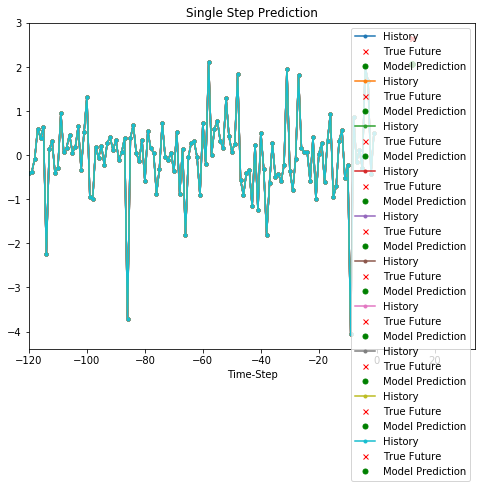

In [51]:
for x, y in val_data_single.take(10):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12,
                      'Single Step Prediction')

In [ ]:
single_step_model.save('ltsm_20200220.h5')

In [ ]:
single_step_model = tf.keras.models.load_model('ltsm_20200220.h5')

In [ ]:
# 그 다음은 multi step model로 해보자. 
# 이게 그 형태인듯. 

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
'''
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape = x_train_single.shape[-2:], return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(16, activation = 'sigmoid'))
single_step_model.add(tf.keras.layers.Dense(1))
'''

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [ ]:
a = []
for x, y in val_data_multi.take(1):
    a.append(multi_step_model.predict(x))

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


In [ ]:
for x, y in val_data_multi.take(1):
    print(x, '---'* 100, y)

In [ ]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
x= val_data_multi.take(1)

In [ ]:
for i in x:
    print(i)

In [ ]:
# 문제 : val_data_multi에는 어떤 데이터가 들어있는가
# 문제 : take(1)은 어떤 의미인가?
# 문제 : mul